In [1]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
import pandas as pd

from pathlib import Path

In [ ]:
# Folder path
path = Path("../data/selected")

# Load data (already split)
X_train = pd.read_csv(path / "X_train_selected.csv")
y_train = pd.read_csv(path / "y_train.csv")

print(X_train.shape)

(1934, 14)


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)
print(X_train.shape, X_val.shape)

(1237, 14) (310, 14)


In [19]:
RANDOM_STATE = 42
CV_SPLITS = 5
SEARCH_ITER = 20
SCORING = "roc_auc_ovr"  # chosen because we will tune threshold later; could be recall_macro or f1_macro

# The pipeline with forward feature selection
pipe = Pipeline(
    steps=[
        (
            "feature_selection",
            SequentialFeatureSelector(
                estimator=SVC(probability=True, random_state=RANDOM_STATE),
                direction="forward",
                # n_features_to_select="auto",
                scoring=SCORING,
                cv=CV_SPLITS,
                n_jobs=-1,
            ),
        ),
        (
            "svm",
            SVC(probability=True, random_state=RANDOM_STATE),
        ),
    ]
)

# Define the hyperparameter search space (still for the final SVM)
search_space = {
    "svm__C": Real(1e-3, 1e3, prior="log-uniform"),
    "svm__gamma": Real(1e-4, 1e1, prior="log-uniform"),
    "svm__kernel": Categorical(["rbf", "linear"]),
    "feature_selection__n_features_to_select": Integer(5, X_train.shape[1] - 1),
}

# Stratified CV for the outer Bayes search
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

# Bayesian search wrapper
bayes_search = BayesSearchCV(
    estimator=pipe,
    search_spaces=search_space,
    n_iter=SEARCH_ITER,
    cv=cv,
    scoring=SCORING,
    n_jobs=-1,
    refit=True,
    random_state=RANDOM_STATE,
    verbose=0,
)

In [20]:
import warnings

warnings.filterwarnings("ignore")
bayes_search.fit(X_train, y_train)

best_model = bayes_search.best_estimator_

In [23]:
print("Mean score:", bayes_search.best_score_)
print("Best params:", bayes_search.best_params_)

Mean score: 0.9358717019331243
Best params: OrderedDict([('feature_selection__n_features_to_select', 5), ('svm__C', 1000.0), ('svm__gamma', 0.05249074016932283), ('svm__kernel', 'rbf')])


In [24]:
sfs = best_model.named_steps["feature_selection"]

selected_mask = sfs.get_support()
selected_features = X_train.columns[selected_mask]

print("Selected features:", list(selected_features))

Selected features: ['cat__BehavioralProblems_1', 'cat__MemoryComplaints_0', 'num__ADL', 'num__FunctionalAssessment', 'num__MMSE']


AUC: 0.9475085812356979


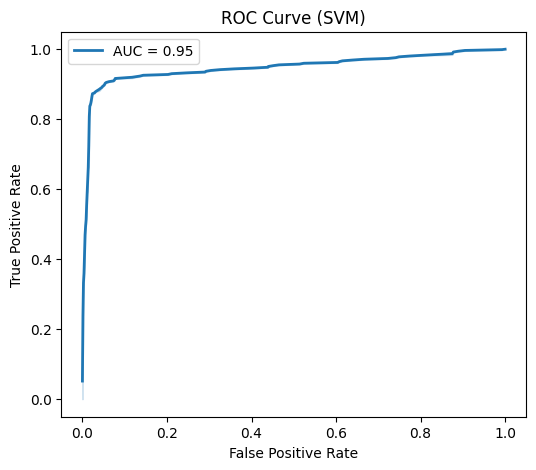

In [25]:
import sys

sys.path.append(".")
sys.path.append("..")

from helpers.roc_utils import plot_roc

auc = plot_roc(best_model, X_train, y_train, title="ROC Curve (SVM)")
print("AUC:", auc)

In [26]:
import pickle

model_path = Path("../data/models")
model_path.mkdir(parents=True, exist_ok=True)

with open(model_path / "SVM_best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

## Picking threshold


In [27]:
import pickle
from pathlib import Path

model_path = Path("../data/models") / "SVM_best_model.pkl"

with open(model_path, "rb") as f:
    loaded_model = pickle.load(f)

In [ ]:
from sklearn.metrics import fbeta_score
import numpy as np

probs = best_model.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0, 1, 200)
best_t = None


thresholds = np.linspace(0, 1, 200)
scores = [fbeta_score(y_val, (probs >= t).astype(int), beta=2) for t in thresholds]
best_t = thresholds[np.argmax(scores)]

np.float64(0.3316582914572864)

In [47]:
best_t

np.float64(0.3316582914572864)

## Evaluation


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import numpy as np


def evaluate_at_threshold(model, X, y, threshold: float, model_name: str = "Model"):
    """
    Evaluate a probabilistic classifier at a fixed threshold.
    Prints confusion matrix, precision, recall, specificity
    and returns them in a dict.
    """
    # 1. Probabilities & hard predictions
    probs = model.predict_proba(X)[:, 1]
    y_pred = (probs >= threshold).astype(int)

    # 2. Confusion matrix
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # 3. Metrics
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred)  # sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

    # 4. Print nicely
    print(f"\n=== {model_name} @ threshold = {threshold:.3f} ===")
    print("Confusion matrix (rows = true, cols = predicted):")
    print(cm)
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"Precision : {precision:.3f}")
    print(f"Recall    : {recall:.3f}")
    print(f"Specificity: {specificity:.3f}")

    return {
        "confusion_matrix": cm,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
    }

In [56]:
path = Path("../data/selected")
X_test = pd.read_csv(path / "X_test_selected.csv")
y_test = pd.read_csv(path / "y_test.csv")

In [ ]:
results_svm = evaluate_at_threshold(best_model, X_test, y_test, best_t)
results_svm


=== Model @ threshold = 0.332 ===
Confusion matrix (rows = true, cols = predicted):
[[127  12]
 [  5  71]]
TN: 127, FP: 12, FN: 5, TP: 71
Precision : 0.855
Recall    : 0.934
Specificity: 0.914


{'confusion_matrix': array([[127,  12],
        [  5,  71]]),
 'TN': np.int64(127),
 'FP': np.int64(12),
 'FN': np.int64(5),
 'TP': np.int64(71),
 'precision': 0.8554216867469879,
 'recall': 0.9342105263157895,
 'specificity': np.float64(0.9136690647482014)}